<a href="https://colab.research.google.com/github/ziatdinovmax/ChemDisc/blob/main/ChemDisc_notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine learning discovery of chemical transformation pathways from atomically-resolved imaging data - Notebook II



In this notebook we are going to analyze elementary building blocks of our experimental graphene system using variational autoencoder with rotational invariance.

*Experimental data from Ondrej Dyck*

*Notebook prepared by Maxim Ziatdinov and Sergei V. Kalinin*

## Imports / Installations / Downloads

Install AtomAI:

In [1]:
!pip install atomai==0.5.2 > /dev/null

Our training data will be a stack of subimages extracted around atoms in the semantically segmented experiemntal images. Here we download the atomic coordinates and the semantically segmentated experiemntal data, as well as the original experimental images.

In [2]:
!gdown "https://drive.google.com/uc?id=1mpecY83LV0sqDbsCzvGgBw4XUhSkiTqZ"

Downloading...
From: https://drive.google.com/uc?id=1mpecY83LV0sqDbsCzvGgBw4XUhSkiTqZ
To: /content/Gdata_for_VAE0.npz
968MB [00:16, 57.3MB/s]


Imports:

In [3]:
from collections import Counter
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
import atomai as aoi

## Create training set for VAE

Load data into the notebook:

In [4]:
data = np.load("Gdata_for_VAE0.npz", allow_pickle=True)
coordinates, dcnn_out, imgdata = data.values()
coordinates = coordinates[()]  # array to dict

Create a stack of submimages centered around a portion of the identified lattice atoms:

In [5]:
imstack_C, com_C, frames_C = aoi.utils.extract_random_subimages(
    dcnn_out, window_size=70, num_images=600, 
    coordinates=coordinates, coord_class=0)
imstack_C = imstack_C[..., 0]  # get rid of pseudo-channel dimension
print(imstack_C.shape)

(60000, 70, 70)


Same for impurities:

In [6]:
imstack_Si, com_Si, frames_Si = aoi.utils.extract_subimages(
    dcnn_out, coordinates,
    window_size=70, coord_class=1)
imstack_Si = imstack_Si[..., 0] # get rid of pseudo-channel dimension
print(imstack_Si.shape)

(1654, 70, 70)


In [7]:
add_impurities = True

if add_impurities:
    imstack = np.concatenate((imstack_C, imstack_Si), axis=0)
    com = np.concatenate((com_C, com_Si), axis=0)
    frames_all = np.concatenate((frames_C, frames_Si))
else:
    imstack = imstack_C
    com = com_C
    frames_all = frames_C
print(imstack.shape, com.shape, frames_all.shape)

(61654, 70, 70) (61654, 2) (61654,)


Initialize rotationally invariant VAE and do the training OR load the already pretrained model.

In [8]:
load_pretrained = True

if load_pretrained:
    !gdown -q "https://drive.google.com/uc?id=19isfR3aWE_GD-Xqg-JJCzT6HFcrvID0I"
    rvae = aoi.load_vae_model("rVAE_G_w70.tar")

else:    
    rvae = aoi.atomstat.rVAE(
        imstack, numlayers_decoder=4, numlayers_encoder=4,
        numhidden_encoder=256, numhidden_decoder=256, skip=True,
        training_cycles=1600)
    # Train
    rvae.run()

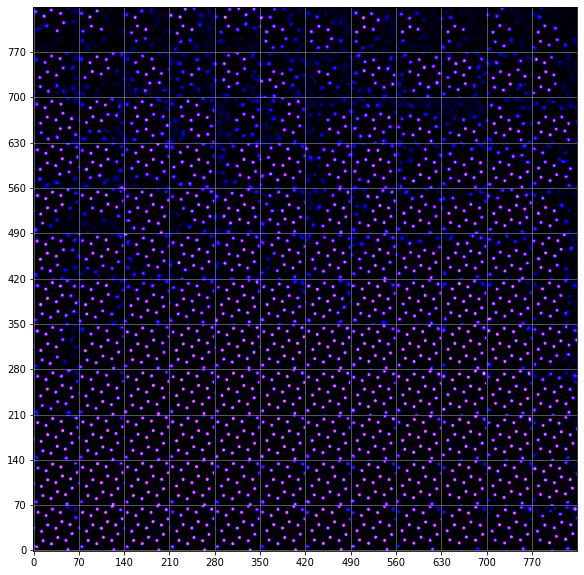

In [9]:
rvae.manifold2d(d=12, cmap='gnuplot2', draw_grid=True)

Let's encode image data and display values of latent variables for each subimage (since each subimage is centered on atom, the resultant scatter plot is a color-coded graphene lattice)

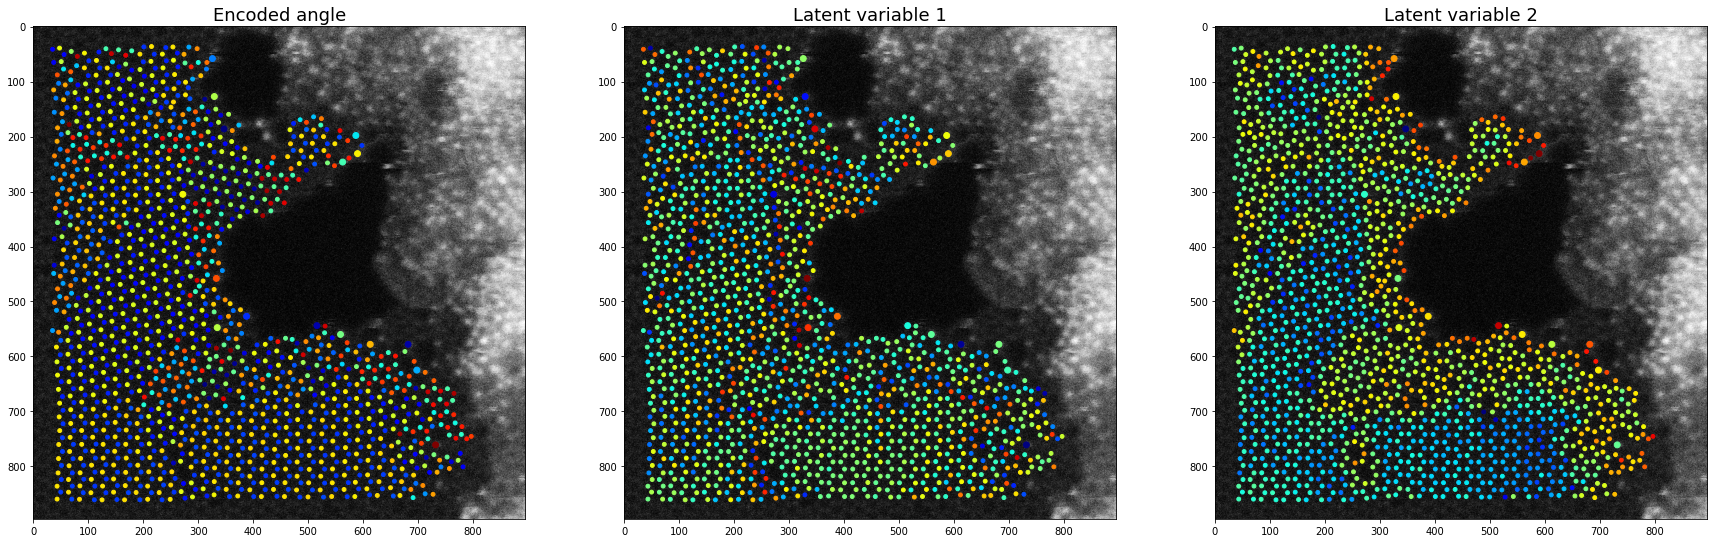

In [ ]:
i = 63 # select frame

imstack_i_C, com_i_C, frames_i_C = aoi.utils.extract_subimages(
    dcnn_out[i:i+1], coordinates[i], window_size=70, coord_class=0)
imstack_i_Si, com_i_Si, frames_i_Si = aoi.utils.extract_subimages(
    dcnn_out[i:i+1], coordinates[i], window_size=70, coord_class=1)

z_C, _ = rvae.encode(imstack_i_C)
z_Si, _ = rvae.encode(imstack_i_Si)
z1_C, z3_C = z_C[:, 0], z_C[:, 3:] 
z1_Si, z3_Si = z_Si[:, 0], z_Si[:, 3:]



fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(imgdata[i], cmap="gray")
ax[0].scatter(com_i_C[:, 1], com_i_C[:, 0], c=z1_C, s=15, cmap="jet")
ax[0].set_title("Encoded angle", fontsize=18)
ax[1].imshow(imgdata[i], cmap="gray")
ax[1].scatter(com_i_C[:, 1], com_i_C[:, 0], c=z3_C[:, 0], s=15, cmap='jet')
ax[1].set_title("Latent variable 1", fontsize=18)
ax[2].imshow(imgdata[i], cmap="gray")
ax[2].scatter(com_i_C[:, 1], com_i_C[:, 0], c=z3_C[:, 1], s=15, cmap="jet")
ax[2].set_title("Latent variable 2", fontsize=18)

ax[0].scatter(com_i_Si[:, 1], com_i_Si[:, 0], c=z1_Si, s=35, cmap="jet")
ax[1].scatter(com_i_Si[:, 1], com_i_Si[:, 0], c=z3_Si[:, 0], s=35, cmap='jet')
ax[2].scatter(com_i_Si[:, 1], com_i_Si[:, 0], c=z3_Si[:, 1], s=35, cmap="jet")

Nexr we are going to map a number of different carbon rings for each point in the latent space and create a "chemical space map". Let's first do it for a single point to show how it works:

(-0.5, 69.5, -0.5, 69.5)

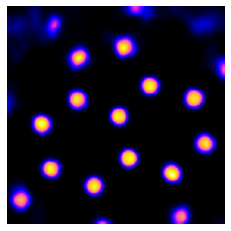

In [ ]:
latent_coord = [.75, 0.2]
decoded = rvae.decode(np.array(latent_coord))[0]
plt.imshow(decoded, origin="lower", cmap="gnuplot2", interpolation="Gaussian")
plt.axis("off")

Get positions of atoms in decoded image using standard ```atomnet.locator``` method:

In [ ]:
coord = aoi.atomnet.locator(threshold=0.5, dist_edge=2).run(decoded[None, ..., None]) # 'None's are for pseudo batch and pseudo channel dims
coord = coord[0] # get a numpy array

Define dictionary that maps classes in ```atomnet.locator``` output to a string with element name:

In [ ]:
map_dict = {
    0: "C",
    1: "Si", #  we have only one class (single-channel rVAE), but this is just an example 
}

Now let's construct a graph from atomic coordinates and plot it:

(note that we need to specify a max allowable C-C bond length in pixels)

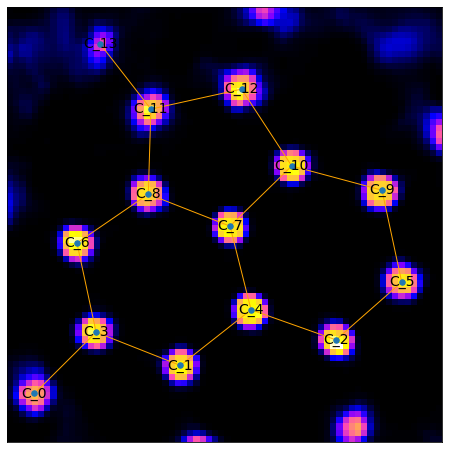

In [ ]:
g = aoi.utils.construct_graph(coord, max_edge_length=19, map_dict=map_dict) # convert max allowable C-C bond length to pixels
aoi.utils.plot_graph(g, decoded)

Identify all rings in the constructed graph:

In [ ]:
rings = aoi.utils.find_all_cycles(g)
for r in rings:
    print("ring size: {}, ring nodes: {}".format(len(r), r))

ring size: 6, ring nodes: ['C_1', 'C_3', 'C_4', 'C_6', 'C_7', 'C_8']
ring size: 5, ring nodes: ['C_10', 'C_11', 'C_12', 'C_7', 'C_8']
ring size: 6, ring nodes: ['C_10', 'C_2', 'C_4', 'C_5', 'C_7', 'C_9']


Find cycles (rings) containing a particular node:

In [ ]:
xc = yc = decoded.shape[0] / 2 # coordinates of center
nv = aoi.utils.adj_cycles(g, rings, (xc, yc))
print(*nv)

6 5 6


Now let's do the same for the entire learned manifold:

In [ ]:
n, m = rvae.im_dim
d = 200
figure = np.zeros((n * d, m * d))
figure_d = np.zeros((d, d, 4)) - 1 # -1 for "unphysical"
grid_idx = []
grid_vals = []
# Construct grid of latent variable values
grid_x = np.linspace(-3, 3, d)
grid_y = np.linspace(-3, 3, d)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        decoded_i = rvae.decode(z_sample)
        coord = aoi.atomnet.locator(
            threshold=0.5, dist_edge=0).run(decoded_i[..., None])
        coord = coord[0]
        g = aoi.utils.construct_graph(coord, max_edge_length=19, map_dict=map_dict)
        rings = aoi.utils.find_all_cycles(g)
        if len(rings) == 0:
            sub_graphs = list(g.subgraph(c).copy() for c in nx.connected_components(g))
            if any([len(sg) > 3 for sg in sub_graphs]):
                nv = {k: 0 for k in range(5, 9)}
                figure[i * n: (i + 1) * n, j * m: (j + 1) * m] = decoded_i
                figure_d[i, j, 0] = nv[5]
                figure_d[i, j, 1] = nv[6]
                figure_d[i, j, 2] = nv[7]
                figure_d[i, j, 3] = nv[8] 
            grid_idx.append(z_sample)
            grid_vals.append(figure_d[i, j][None, ...]) 
            continue
        nv = Counter(aoi.utils.adj_cycles(g, rings, (xc, yc)))
        v_sum = sum([v for v in nv.values()])
        if v_sum < 4: 
            figure[i * n: (i + 1) * n, j * m: (j + 1) * m] = decoded_i
            figure_d[i, j, 0] = nv[5]
            figure_d[i, j, 1] = nv[6]
            figure_d[i, j, 2] = nv[7]
            figure_d[i, j, 3] = nv[8]
        grid_idx.append(z_sample)
        grid_vals.append(figure_d[i, j][None, ...]) 
grid_idx = np.concatenate(grid_idx)
grid_vals = np.concatenate(grid_vals)

(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 <a list of 7 Text major ticklabel objects>)

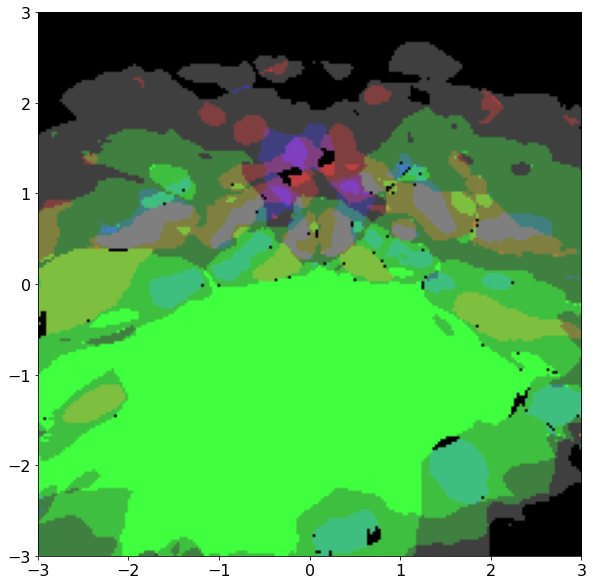

In [ ]:
plt.figure(figsize=(10, 10))
figure_d_t = np.transpose(figure_d.copy(), (1, 0, -1))
figure_d_t = (figure_d_t - figure_d_t.min()) / figure_d_t.ptp()
plt.imshow(figure_d_t[..., 0:3], origin="lower", extent=(-3, 3, -3, 3))
plt.xticks(size=16)
plt.yticks(size=16)

Finally, we are going to track trajectories of impurities in both real space and latent space.

In [ ]:
# Create coordinate dictionary only for impurities
coordinates_filtered_ = {}
for k, v in coordinates.items():
    coordinates_filtered_[k] = deepcopy(v[v[:, -1] == 1.]) 

In [ ]:
# Set impurity class to 0 so that it works with a trajectory finder
for k, v in coordinates_filtered_.items():
    coordinates_filtered_[k][:, -1] = v[:, -1] - 1 

Get trajectories:

In [ ]:
trajs, frames, subimgs = rvae.encode_trajectories(
    dcnn_out[..., 0], coordinates_filtered_, window_size=70, min_length=5, rmax=32)

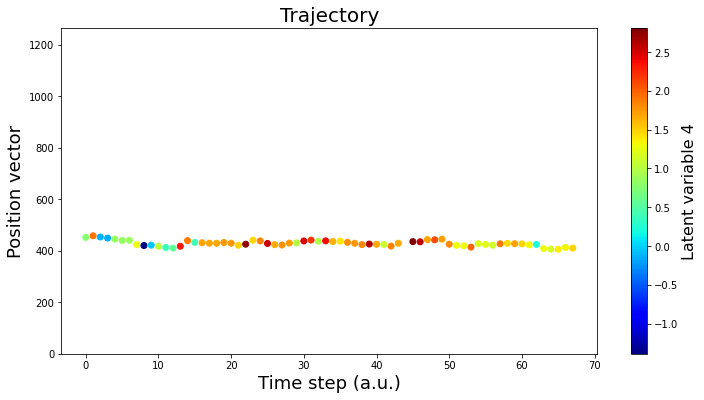

In [ ]:
k = 6 # 6, 7, 8
aoi.utils.plot_trajectories(trajs[k], frames[k], fov=896, lv=4)

Here we can filter trajectories for speciifc frame range:

In [ ]:
cond = (frames[k] >= 0) & (frames[k] < 200)

frames_i = frames[k][cond]
trajs_i = trajs[k][cond]

Plot trajectories in latent space:

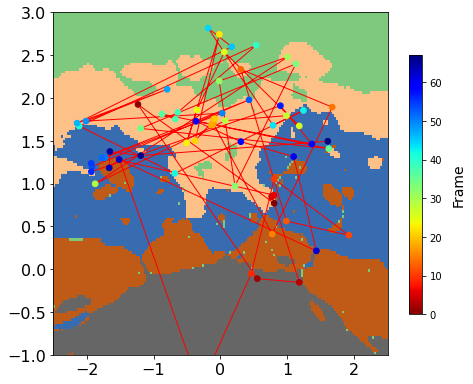

In [ ]:
cmap = "jet_r"

cvals = np.arange(len(trajs_i))
clrbar = np.linspace(frames_i.min(), frames_i.max()).reshape(-1, 1)
fig, ax1 = plt.subplots(1, 1, figsize=(6., 6.3))
ax1.scatter(grid_idx[:, 0], grid_idx[:, 1], marker='s', c=grid_vals[:, 1], cmap='Accent')
ax1.scatter(trajs_i[:, -2], trajs_i[:, -1], s=32, c=cvals, cmap=cmap, zorder=2)
ax1.plot(trajs_i[:, -2], trajs_i[:, -1], c="red", linewidth=1, alpha=1, zorder=1)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

ax2 = fig.add_axes([.78, .1, .2, .8])
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-1, 3)
img = plt.imshow(clrbar, cmap=cmap)
plt.gca().set_visible(False)
clrbar_ = plt.colorbar(img, ax=ax2, orientation='vertical')
clrbar_.set_label('Frame', fontsize=14, labelpad=10)
plt.show()

# Watermarks

In [10]:
!pip install watermark > /dev/null

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy    1.18.5
atomai   0.5.2
networkx 2.5
last updated: Mon Oct 19 2020 

CPython 3.6.9
IPython 5.5.0
watermark 2.0.2
